In [324]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback
from sklearn import preprocessing
from ucimlrepo import fetch_ucirepo 

import seaborn as sns

In [325]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [326]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [327]:
dataset_name = "credit"

In [328]:
# fetch dataset 
credit_approval = fetch_ucirepo(id=27) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 

{'uci_id': 27, 'name': 'Credit Approval', 'repository_url': 'https://archive.ics.uci.edu/dataset/27/credit+approval', 'data_url': 'https://archive.ics.uci.edu/static/public/27/data.csv', 'abstract': 'This data concerns credit card applications; good mix of attributes', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 690, 'num_features': 15, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['A16'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1987, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C5FS30', 'creators': ['J. R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.\r\n  \r\nThis dataset is interesting because there is a good mix of attributes --

In [329]:
categorical_cols = ['A13', 'A12', 'A10', 'A9', 'A7', 'A6', 'A5', 'A4', 'A1']
# One-hot encode the categorical columns
df_encoded = pd.get_dummies(X, columns=categorical_cols)
# Initialize a scaler
scaler = preprocessing.StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = X.fillna(0)
# to numpy
X = X.values

In [330]:
y = np.array([1.0 if elem == "+" else 0.0 for elem in y["A16"]])

In [331]:
from sklearn import model_selection

In [332]:
X, Xtest, y, ytest = model_selection.train_test_split(X, y)

In [333]:
y.mean()

0.44294003868471954

In [334]:
ytest.sum()

78.0

## Specify learning algorithms

In [546]:
import math


def sigmoid(x):
    x = np.clip(x, -200, 200)
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    #print(f"{X=}")
    #print(f"{theta.T=}")
    #print(f"{y=}")
    y = sigmoid(y)
    #print(f"{y=}")
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-45):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    #print(f"{p=}")
    #print(f"{y=}")
    #print(f"{l=}")
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [547]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-45,
    max_iterations = 6500
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = min(X.shape[0], max_iterations)  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        #print(f"{p=}")
        #print(f"{yy=}")
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        #print(f"{p=}")
        #print(f"{ytest=}")
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 10 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))} acc: {accuracies[i]}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [548]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [549]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [550]:
hyperparam_per_algo["absloss"] = {"eta": 0.1}
hyperparam_per_algo["random"] = {"eta": 0.1}
hyperparam_per_algo["polyak_absloss"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.99,
    "omega": 1.1
}
hyperparam_per_algo["polyak_exponent"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.99,
    "omega": 1.1
}

In [551]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.1},
 'polyak_exponent': {'kappa': 10,
  'kappa0': 0.99,
  'eta': 0.1,
  'polyakexp': 0.9951814804061615,
  'omega': 1.1},
 'absloss': {'eta': 0.1},
 'random': {'eta': 0.1}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [552]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 517 iterations with d=46
loss: 0.6376768741897013, train loss: 0.6931471805599453, ||theta||_1: 1.322403642014407 acc: 0.5
loss: 0.5874921985314701, train loss: 1.2359617123981879, ||theta||_1: 2.4912297714843445 acc: 0.0
loss: 0.5785233310033364, train loss: 0.7655301091975159, ||theta||_1: 3.9346298413916276 acc: 0.0
loss: 0.6004812739058842, train loss: 0.22793268617103873, ||theta||_1: 4.412715918687614 acc: 1.0
loss: 0.5555364482882185, train loss: 0.5608791660445324, ||theta||_1: 5.528115948238112 acc: 1.0
loss: 0.5413750574385731, train loss: 0.2073513789975978, ||theta||_1: 6.004083175854642 acc: 1.0
loss: 0.5413307198506849, train loss: 0.1765775096627646, ||theta||_1: 6.6191584003618456 acc: 1.0
loss: 0.5543974786462136, train loss: 1.2780321390316698, ||theta||_1: 7.115863800277289 acc: 0.0
loss: 0.5040093619726314, train loss: 0.18962717243362556, ||theta||_1: 6.9913336015245475 acc: 1.0
loss: 0.4825106068154714, train loss: 0.12062215341981

In [553]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [554]:
absloss_mean_sampling_prob

0.2779196727165938

In [555]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 517 iterations with d=46
loss: 0.6376768741897013, train loss: 0.6931471805599453, ||theta||_1: 1.322403642014407 acc: 0.5
loss: 0.679930939241682, train loss: 0.9168782809816991, ||theta||_1: 2.1921464435682867 acc: 0.0
loss: 0.5817312029257243, train loss: 0.7385059859298084, ||theta||_1: 3.6897037710118674 acc: 0.0
loss: 0.6310081931057039, train loss: 0.6201668171784004, ||theta||_1: 4.346332250517531 acc: 1.0
loss: 0.6101530217393192, train loss: 0.5465094271048105, ||theta||_1: 4.841801273368235 acc: 1.0
loss: 0.5455197725204889, train loss: 0.26582073566323317, ||theta||_1: 5.148640672541598 acc: 1.0
loss: 0.49777951934304887, train loss: 0.9979175180359501, ||theta||_1: 6.090327808598695 acc: 0.0
loss: 0.4575364302309706, train loss: 1.5851982979385775, ||theta||_1: 6.1538802232550935 acc: 0.0
loss: 0.4450900638228641, train loss: 0.22412234895492378, ||theta||_1: 6.452290234687867 acc: 1.0
loss: 0.43934490231034645, train loss: 0.151042256560992

In [556]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 517 iterations with d=46
loss: 0.6931471805599454, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6406235254050128, train loss: 0.6675399069556662, ||theta||_1: 2.235956424524552 acc: 1.0
loss: 0.5212671377449128, train loss: 0.7227596661607253, ||theta||_1: 3.106748495711024 acc: 0.0
loss: 0.5140481219739905, train loss: 0.2617132329357867, ||theta||_1: 4.051023178690743 acc: 1.0
loss: 0.4957755445204091, train loss: 0.5973895393699291, ||theta||_1: 4.811165667472951 acc: 1.0
loss: 0.4753113712765684, train loss: 0.10007948527663595, ||theta||_1: 4.905866636586821 acc: 1.0
loss: 0.45575556363780784, train loss: 0.035369713147211275, ||theta||_1: 5.057173586215302 acc: 1.0
loss: 0.4439256183189546, train loss: 0.41699691330921906, ||theta||_1: 5.343860956035872 acc: 1.0
loss: 0.4448107382929838, train loss: 0.08311723286276851, ||theta||_1: 5.731951133477359 acc: 1.0
loss: 0.42625581375446076, train loss: 0.34409662797699364, ||theta||

In [557]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 517 iterations with d=46
loss: 0.6376768741897013, train loss: 0.6931471805599453, ||theta||_1: 1.322403642014407 acc: 0.5
loss: 0.6926758922163667, train loss: 0.764446055395807, ||theta||_1: 2.4705969183366663 acc: 0.0
loss: 0.5428787788889033, train loss: 0.6256013640661349, ||theta||_1: 4.0883531022381225 acc: 1.0
loss: 0.5628926355760524, train loss: 0.17707536108245928, ||theta||_1: 4.956613244418078 acc: 1.0
loss: 0.6647720626499822, train loss: 0.8502759252638445, ||theta||_1: 5.386031508160161 acc: 0.0
loss: 0.6597819235102723, train loss: 0.18091448336125365, ||theta||_1: 5.57664229466849 acc: 1.0
loss: 0.6164500830769029, train loss: 0.6385689965761135, ||theta||_1: 6.806043701726742 acc: 1.0
loss: 0.58004645339302, train loss: 0.846674349132587, ||theta||_1: 7.149214642676781 acc: 0.0
loss: 0.47124628300049953, train loss: 0.4333126642714053, ||theta||_1: 6.699639047355767 acc: 1.0
loss: 0.4652034473160077, train loss: 0.18146931522915988, |

In [558]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

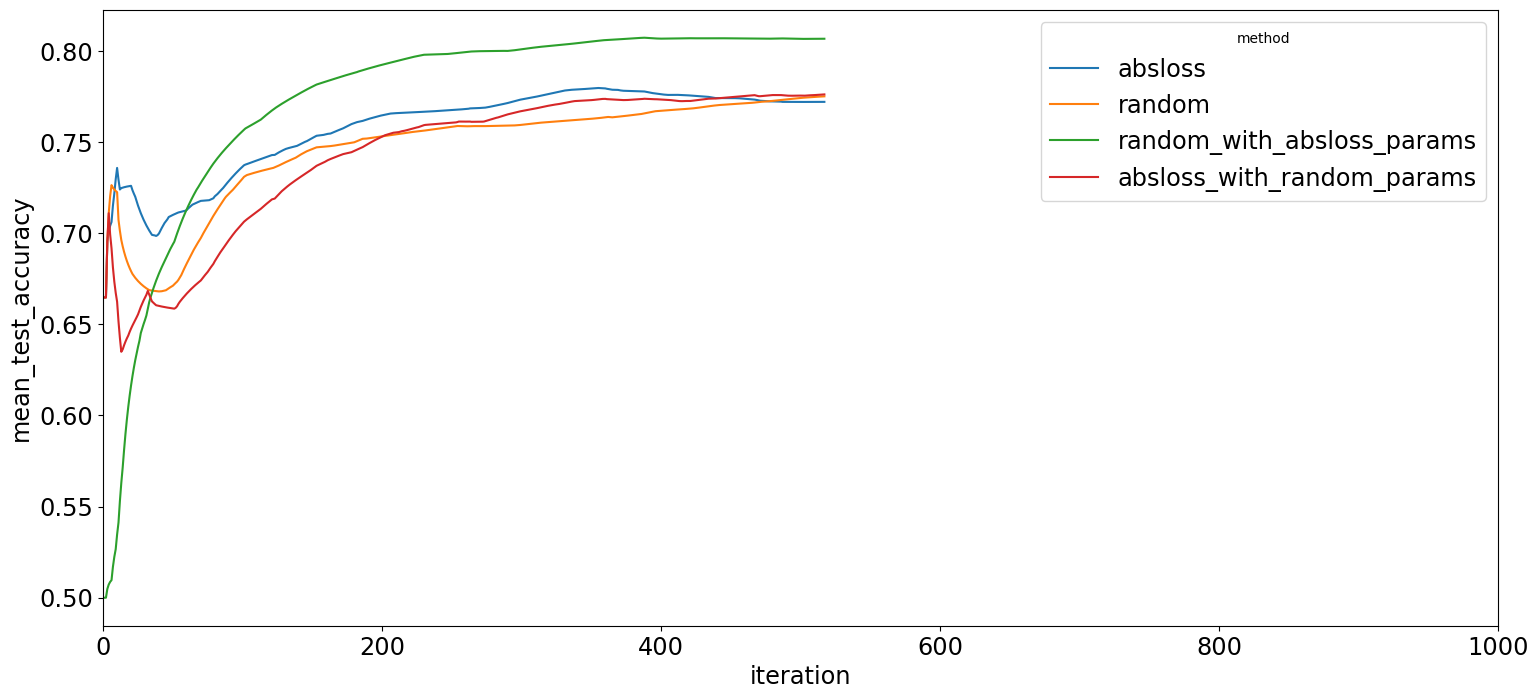

In [559]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

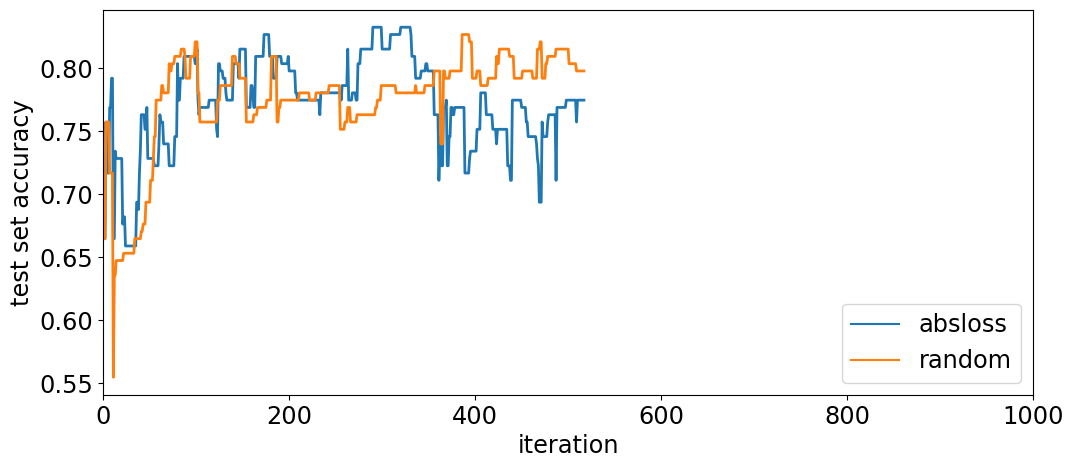

In [560]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig(f"figure_8a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

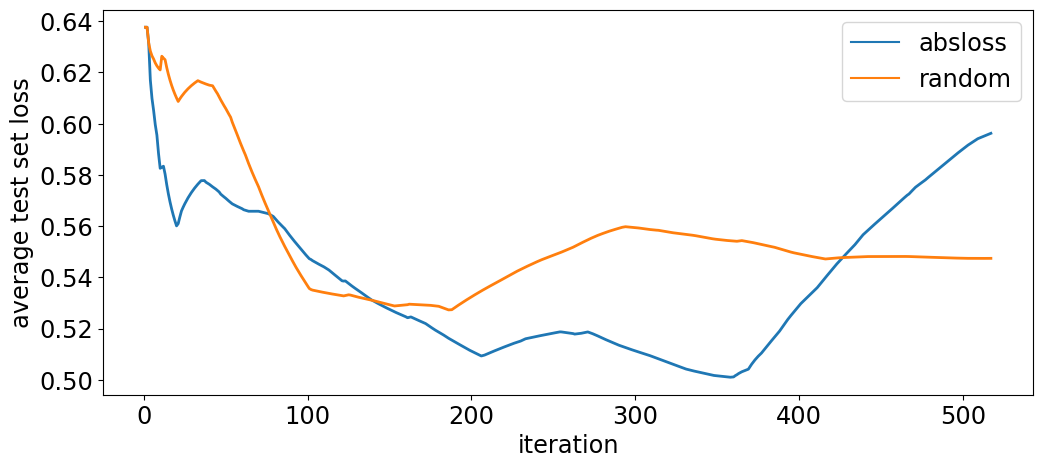

In [561]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_7a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

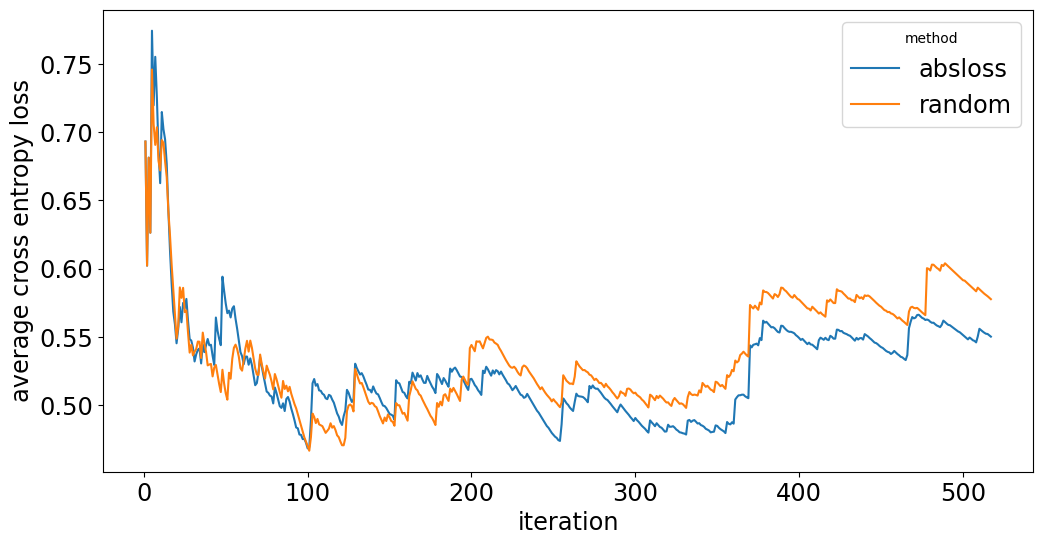

In [562]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

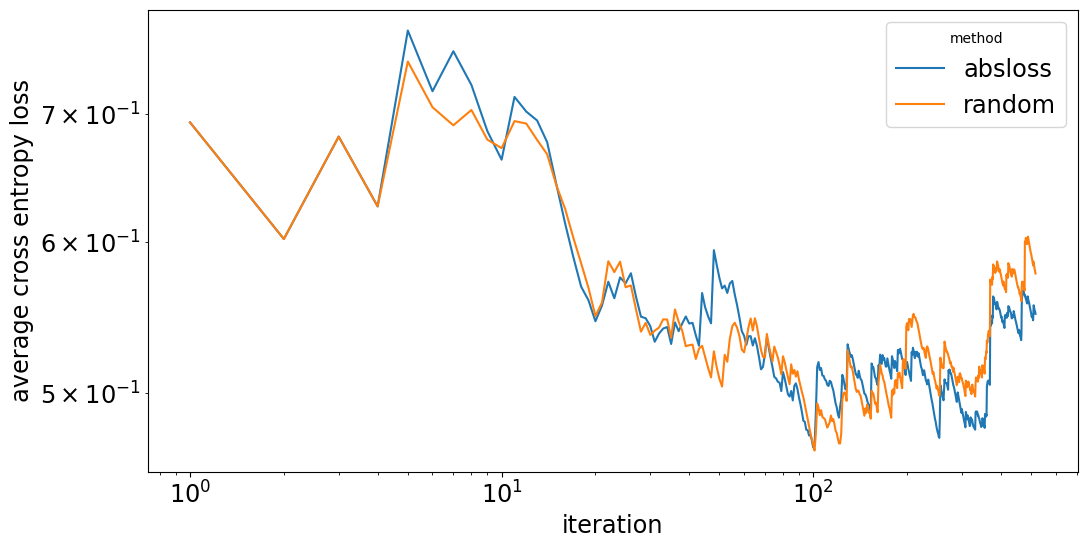

In [563]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [564]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 517 iterations with d=46
loss: 0.6376768741897013, train loss: 0.6931471805599453, ||theta||_1: 1.322403642014407 acc: 0.5
loss: 0.5697857981579064, train loss: 1.5075664536771196, ||theta||_1: 2.2868570087371674 acc: 0.0
loss: 0.5671399707023673, train loss: 1.3728379414700504, ||theta||_1: 4.171181609092326 acc: 0.0
loss: 0.5159539459779695, train loss: 0.1433936485804788, ||theta||_1: 5.323673899128711 acc: 1.0
loss: 0.5160134791382542, train loss: 1.5537748083964569, ||theta||_1: 5.806980857254814 acc: 0.0
loss: 0.4874687094561112, train loss: 0.06410253297460283, ||theta||_1: 6.461585640254626 acc: 1.0
loss: 0.45560513964102894, train loss: 0.03439454210896582, ||theta||_1: 6.928636698045647 acc: 1.0
loss: 0.45691756427728486, train loss: 0.26857474636631573, ||theta||_1: 7.579568891331342 acc: 1.0
loss: 0.44653287214435944, train loss: 0.08749335257353319, ||theta||_1: 7.118749295019317 acc: 1.0
loss: 0.4558764138969395, train loss: 0.0466

In [565]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[58.167987078838806, 29.083993539419403, 17.510308898125363, 8.755154449062681]

In [566]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [567]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [568]:
empirical_pzs

[0.4641971624255152, 0.642662648646463, 0.6768565590387838, 0.8103703766973144]

In [569]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [570]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [571]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs       
polyak_exponent  17.5        6.124889e-26    0.692337
                             9.413747e-16    0.842966
                             3.066399e-14    0.833020
                             1.313070e-13    3.280995
                             1.335698e-13    0.720695
                                               ...   
                 8.8         9.157680e-01    0.971210
random           17.5        6.768566e-01    0.567594
                 29.1        6.426626e-01    0.575857
                 58.2        4.641972e-01    0.515087
                 8.8         8.103704e-01    0.550320
Name: train_loss, Length: 353, dtype: float64

In [572]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs       
polyak_exponent  17.5        6.124889e-26    0.527593
                             9.413747e-16    0.700023
                             3.066399e-14    0.534550
                             1.313070e-13    0.501906
                             1.335698e-13    0.488378
                                               ...   
                 8.8         9.157680e-01    0.390628
random           17.5        6.768566e-01    0.427481
                 29.1        6.426626e-01    0.393388
                 58.2        4.641972e-01    0.449577
                 8.8         8.103704e-01    0.378435
Name: mean_train_loss, Length: 353, dtype: float64

Polyak exp value 58.2 has rows (1034, 16)
Polyak exp value 29.1 has rows (1034, 16)
Polyak exp value 17.5 has rows (1034, 16)
Polyak exp value 8.8 has rows (1034, 16)


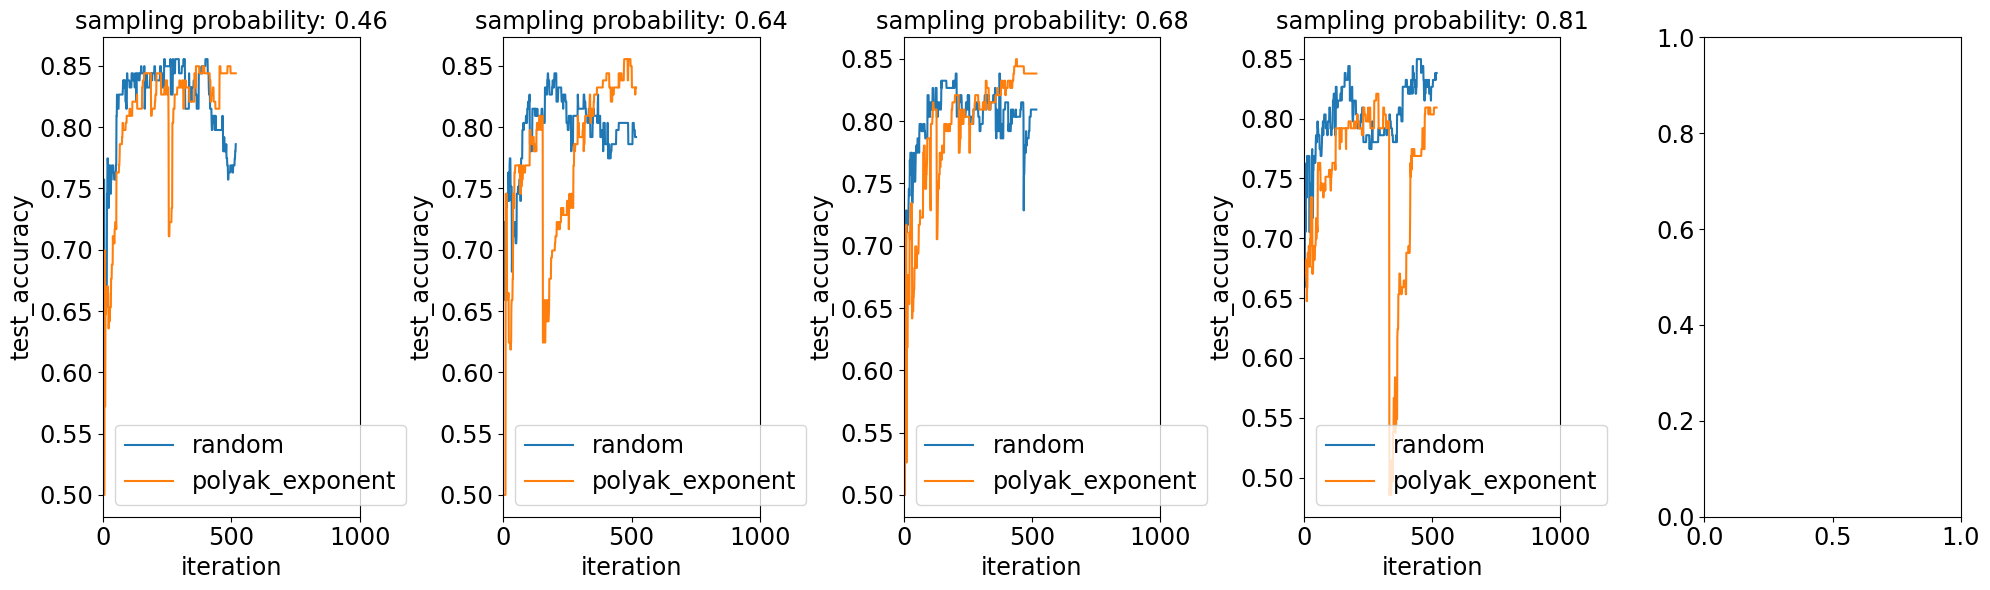

In [573]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 58.2 has rows (1034, 16)
Polyak exp value 29.1 has rows (1034, 16)
Polyak exp value 17.5 has rows (1034, 16)
Polyak exp value 8.8 has rows (1034, 16)


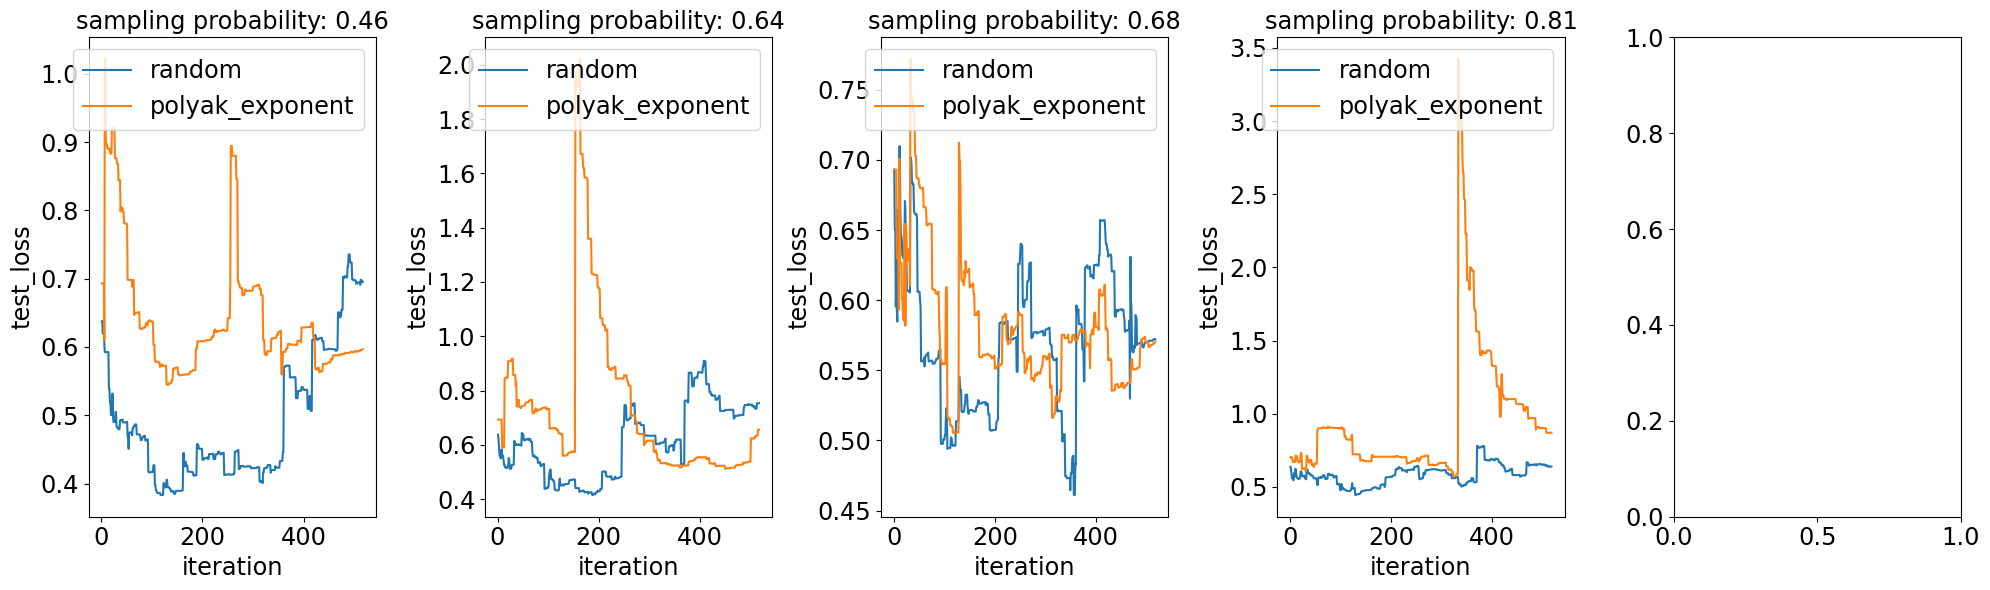

In [574]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [575]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

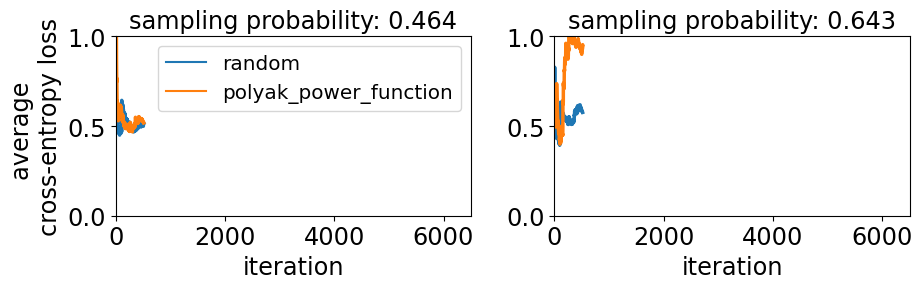

In [576]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

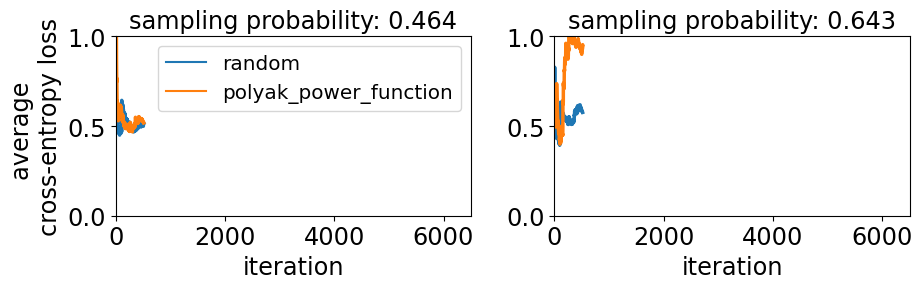

In [577]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

0.4641971624255152
Polyak exp value 58.2 has rows (1034, 16)
0.642662648646463
Polyak exp value 29.1 has rows (1034, 16)
0.6768565590387838
Polyak exp value 17.5 has rows (1034, 16)
0.8103703766973144
Polyak exp value 8.8 has rows (1034, 16)


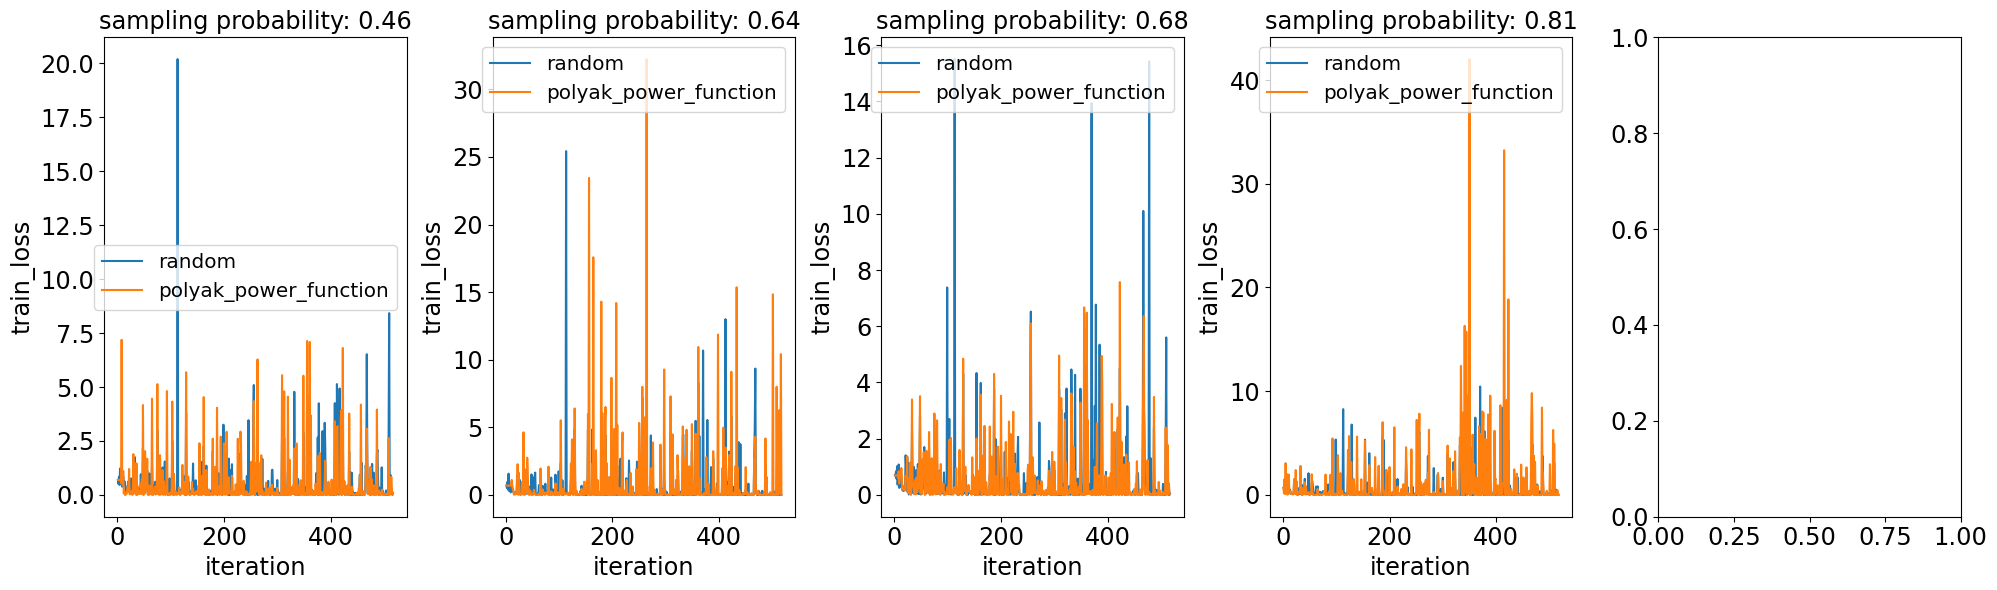

In [578]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.4641971624255152
Polyak exp value 58.2 has rows (1034, 16)
0.642662648646463
Polyak exp value 29.1 has rows (1034, 16)
0.6768565590387838
Polyak exp value 17.5 has rows (1034, 16)
0.8103703766973144
Polyak exp value 8.8 has rows (1034, 16)


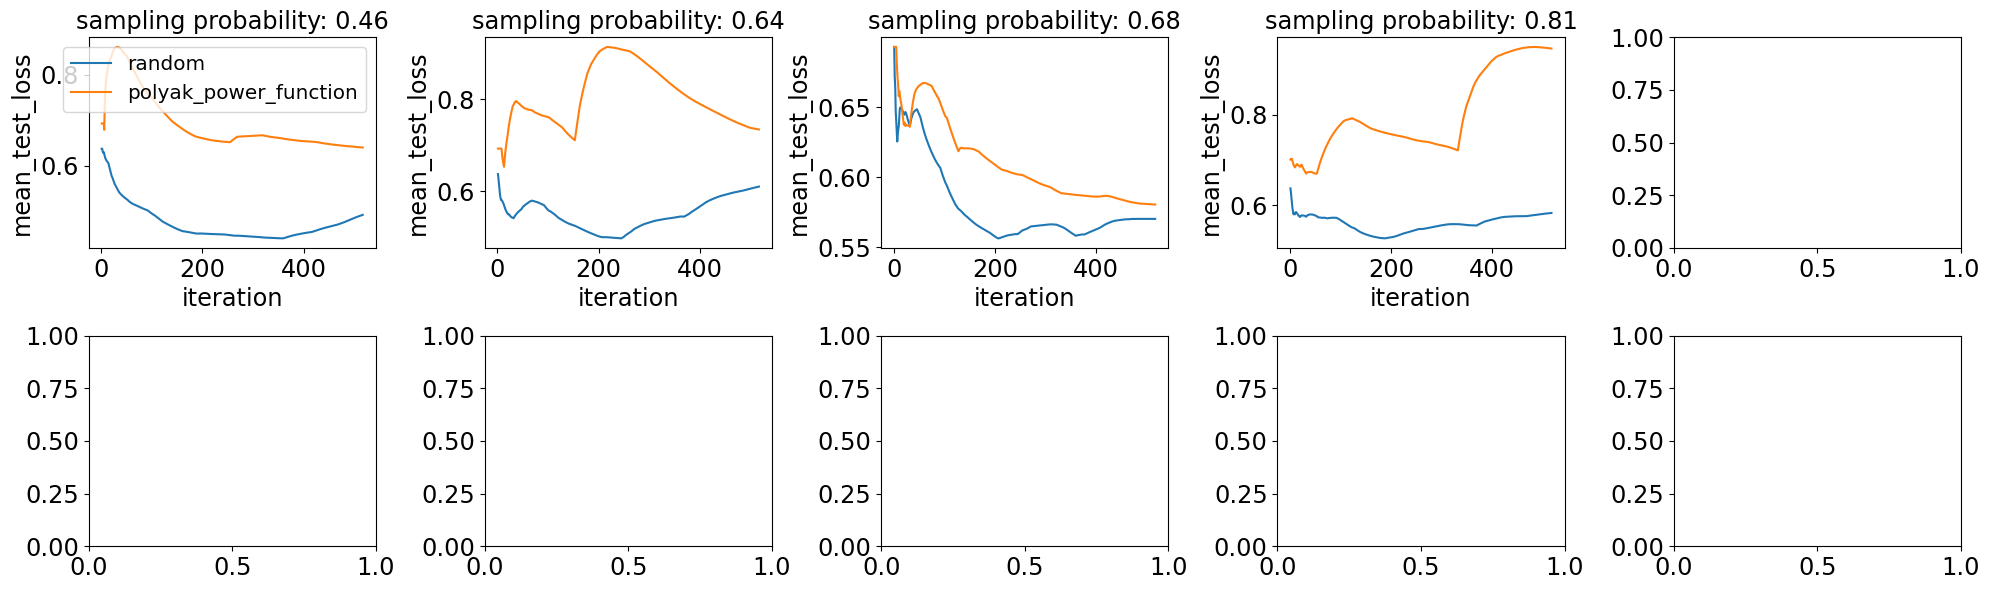

In [579]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [580]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.1}

In [581]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 517 iterations with d=46
loss: 0.6931471805599454, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.5690367053997331, train loss: 1.4386429403324614, ||theta||_1: 3.3478880810062446 acc: 0.0
loss: 0.6212789687256304, train loss: 0.7451370873214519, ||theta||_1: 6.334881696189303 acc: 0.0
loss: 0.5749448852940575, train loss: 0.08965299018975628, ||theta||_1: 6.910520687322404 acc: 1.0
loss: 0.5641094572794191, train loss: 0.4161568085969616, ||theta||_1: 6.107185250862773 acc: 1.0
loss: 0.5811743478722844, train loss: 0.04003309729103584, ||theta||_1: 6.383445299658822 acc: 1.0
loss: 0.568485797120714, train loss: 0.3848612118034289, ||theta||_1: 7.473907330227003 acc: 1.0
loss: 0.597929433712436, train loss: 0.01767833413455024, ||theta||_1: 9.990545206995995 acc: 1.0
loss: 0.597929433712436, train loss: 0.029355358046841563, ||theta||_1: 9.990545206995995 acc: 1.0
loss: 0.6325179691535303, train loss: 0.04003700635779742, ||the

In [582]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.3740712100835804}


In [583]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

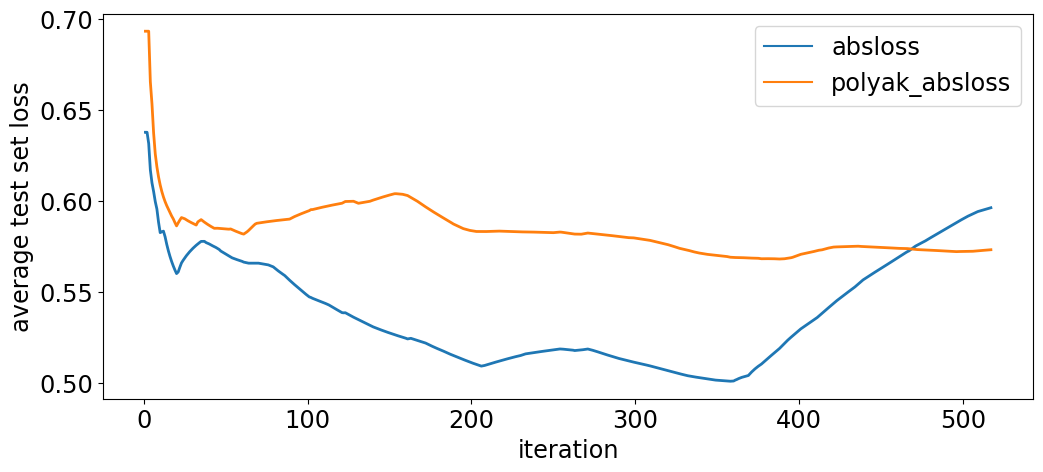

In [584]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig(f"figure_7b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

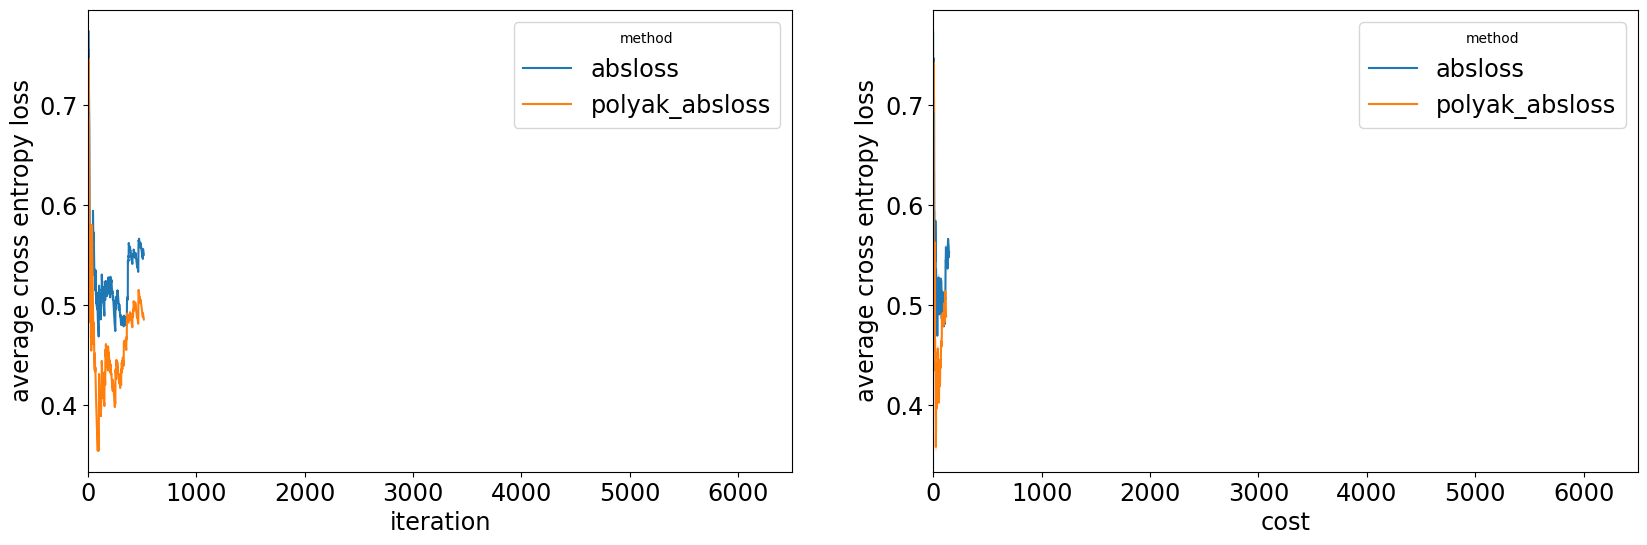

In [585]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

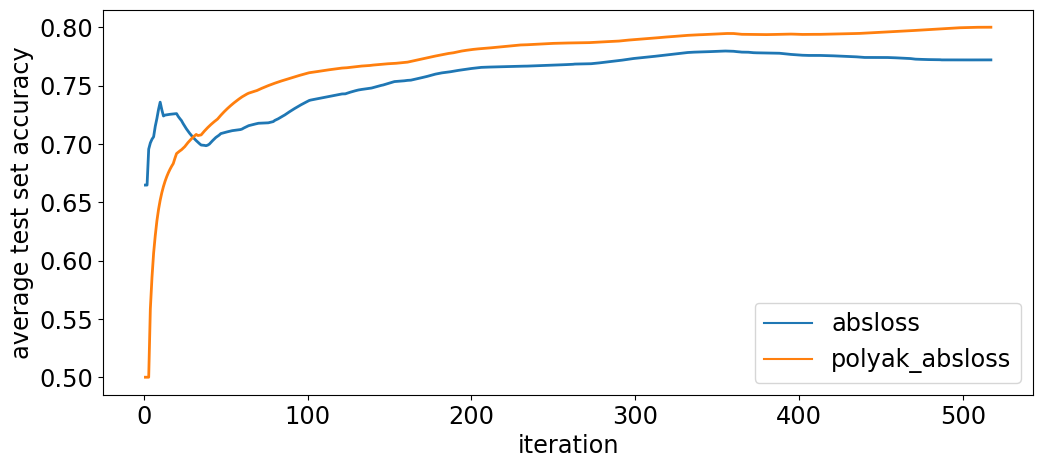

In [586]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_8b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

In [587]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

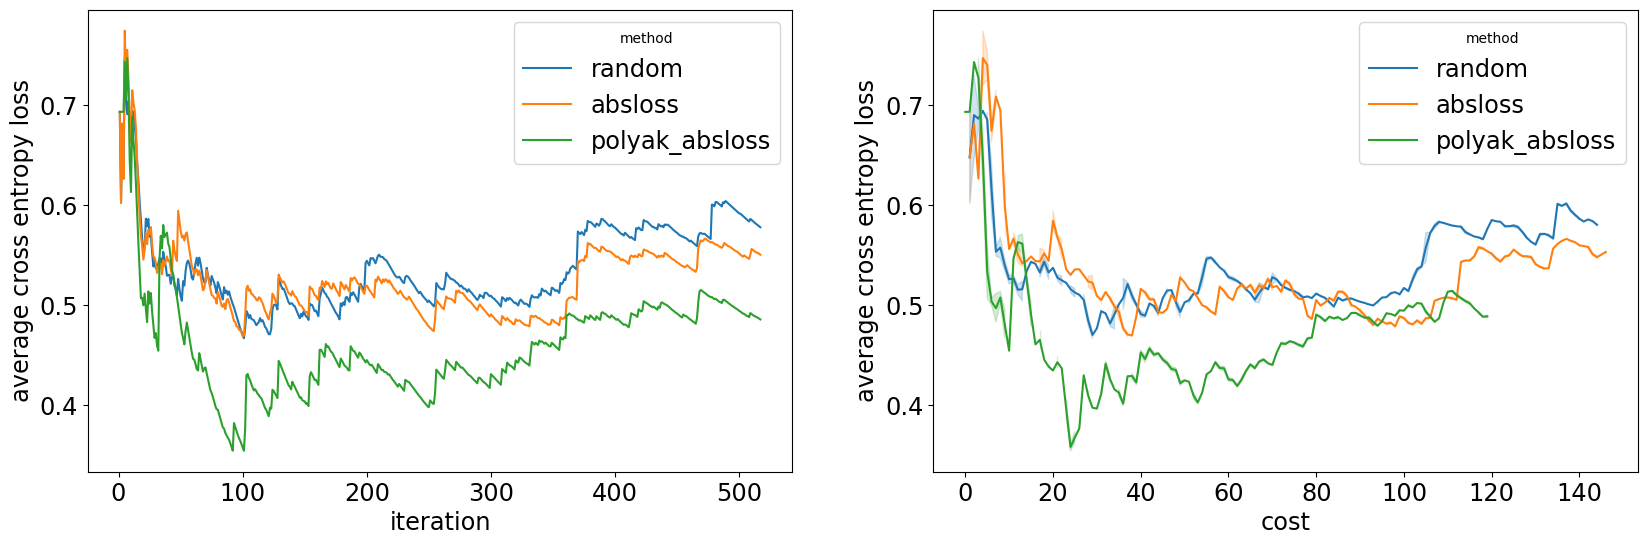

In [588]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

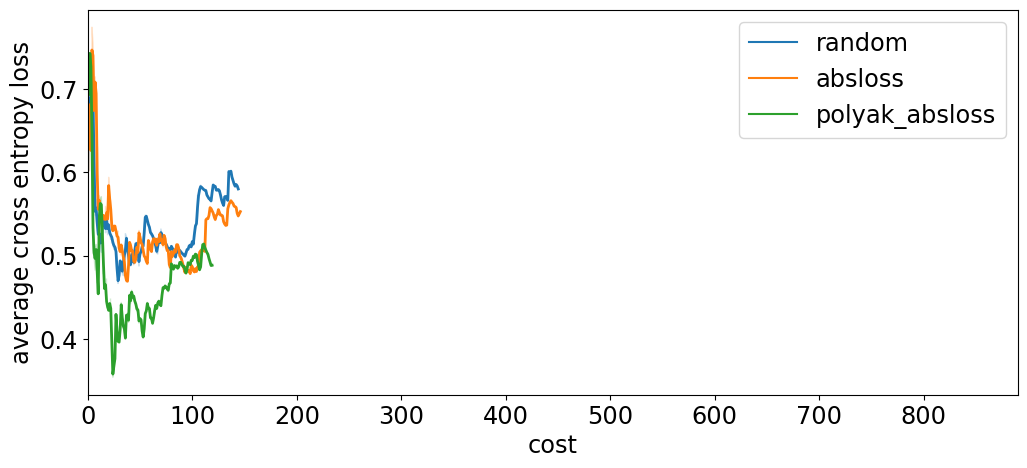

In [589]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_6_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

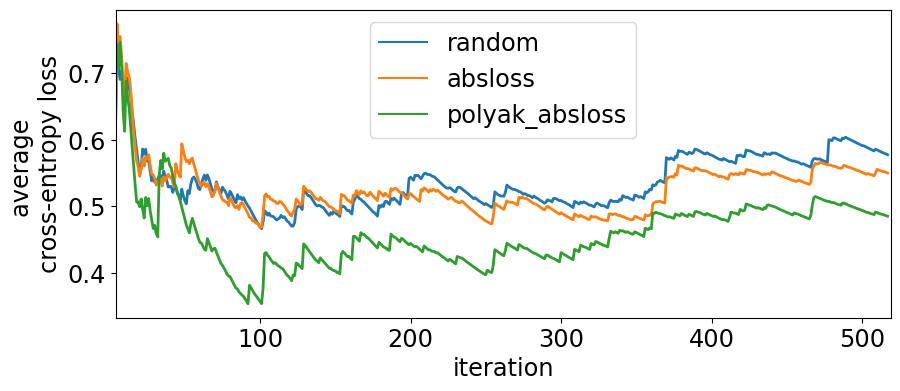

In [597]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')
ax.set_xlim((4, 519))

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig(f"figure_3_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")
